In [1]:
# ref:
# https://github.com/cristian-data-science/machine_learning_projects/blob/c902e5720349fc1d2e3d5a3298daafe8693033a0/cv_load_autogluon.ipynb
# https://blog.csdn.net/wish_to_top/article/details/118031463

In [2]:
import pickle
import pandas as pd

def my_save(List,filename,Global):
    # filename : name.pkl
    my_pickle = {}
    for key in List:
        try:
            my_pickle[key] = Global[key] #globals()[key]
        except TypeError:
            print('ERROR pickleing: {0}'.format(key))
    with open(filename, 'wb') as f:   # Python 3: open(..., 'wb')
        pickle.dump(my_pickle, f)


def my_load(filename,Global):
    with open(filename, 'rb') as f:  # Python 3: open(..., 'rb')
        my_shelf = pickle.load(f)

    for key in my_shelf:
        Global[key] = my_shelf[key]

In [3]:
import pandas as pd
import shap
import os
from collections import Counter
#os.environ['RAY_memory_monitor_refresh_ms'] = "0"
os.environ['RAY_memory_usage_threshold'] = "0.99"
from sklearn.metrics import classification_report


In [ ]:
def get_aucplot(one_model,X,y):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    n_classes = 3
    y_pred = predictor.predict(X, model=one_model)
    y_score = label_binarize(y_pred, classes=[1, 2,3])
    y_true = label_binarize(y, classes=[1, 2,3])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute macro-average ROC curve and ROC area（）
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.plot(all_fpr, mean_tpr,linewidth=3, label='%s (AUC = %0.2f)' % (one_model, roc_auc["macro"])) # Macro
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    return fpr, roc_auc

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

#def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):
def plot_confusion_matrix(cm, title='Confusion Matrix'):

    plt.figure(figsize=(6, 4), dpi=100)
    np.set_printoptions(precision=2)

    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='black', va='center', ha='center')
    plt.imshow(cm, interpolation='nearest', cmap="YlGnBu") #viridis
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
#    plt.savefig(savename, format='png')
    plt.show()

In [6]:
def class_pred_calculate(df_stat):
    d_all = pd.DataFrame(df_stat.label.value_counts()).reset_index()
    d_all.columns = ["groupHPD","all_count"]
    d_true = pd.DataFrame(df_stat[df_stat["label"] == df_stat["pred"]].label.value_counts()).reset_index()
    d_true.columns = ["groupHPD","true_count"]
    d_true = pd.merge(d_true,d_all,how="inner",on="groupHPD")
    d_true["percent"] = round(d_true["true_count"] / d_true["all_count"]*100, 2)
    print(d_true,"\n")
    d_false = pd.DataFrame(df_stat[df_stat["label"] != df_stat["pred"]].label.value_counts()).reset_index()
    d_false.columns = ["groupHPD","false_count"]
    d_false = pd.merge(d_false,d_all,how="inner",on="groupHPD")
    d_false["percent"] = round(d_false["false_count"] / d_false["all_count"]*100, 2)
    print(d_false,"\n")
    d_false = d_false[["groupHPD","false_count"]]
    d_false.columns = ["label","false_count"]
    df_stat["count"] = 1
    d_false2 = df_stat[df_stat["label"] != df_stat["pred"]].groupby(["label","pred"]).agg({"count":"count"}).reset_index()
    d_false2 = pd.merge(d_false2,d_false,how="left",on="label")
    print(d_false2,"\n")
    return d_true, d_false, d_false2
# df_stat = pd.concat([y_train,y_pred],axis=1)
# df_stat.columns = ["label", "pred"]
# d_true, d_false, d_false2 = class_pred_calculate(df_stat)

In [7]:
save_path = './Result-b21a1234_raw_dataset_MimiceICU_AUMC_CorrMICfilt/'  # raw_dataset

import os
make_path = save_path + "/input/"
make_path1 = save_path + "/result/"
print(make_path)
if not os.path.exists(make_path):
    os.makedirs(make_path)
if not os.path.exists(make_path1):
    os.makedirs(make_path1)
    
df = pd.read_csv("../00.data_generate/df_saki_self_generate_features_b21a1234_CorrMICfilt.csv")
print(df.shape)

datasplit_type = "train2_test1" # "train2_test1", "train1_test2"
choose_dataset = "aumcdb"  #['eicu','aumcdb', 'mimic']
train_sample_ = 0.7

./Result-b21a1234_raw_dataset_MimiceICU_AUMC_CorrMICfilt//input/
(8866, 103)


# Split the dataset by dataset
One database is the training set and two databases are the test sets
Two databases are the training set and one database is the test set

In [ ]:
def split_traintest(datasplit_type, choose_dataset):
    if datasplit_type == "train1_test2":
        train_dataset = choose_dataset #"mimic"
        dataset_lst = df.dataset.unique().tolist()
        dataset_lst.remove(train_dataset)
        test_dataset1 = dataset_lst[0]
        test_dataset2 = dataset_lst[1]

        train_set = df[df["dataset"]==train_dataset]
        test_set1 = df[df["dataset"]==test_dataset1]
        test_set2 = df[df["dataset"]==test_dataset2]
        
        train_set = train_set.drop(["dataset"],axis=1) 
        test_set1 = test_set1.drop(["dataset"],axis=1)
        test_set2 = test_set2.drop(["dataset"],axis=1)
        data_path = save_path + './input/'
        infile = data_path + "train_set.csv"
        train_set.to_csv(infile,index=False)
        infile = data_path + "test_set1.csv"
        test_set1.to_csv(infile,index=False)
        infile = data_path + "test_set2.csv"
        test_set2.to_csv(infile,index=False)
        
        d1 = train_dataset
        d1_len = len(train_set.stay_id.unique())
        d2 = test_dataset1
        d2_len = len(test_set1.stay_id.unique())
        d3 = test_dataset2
        d3_len = len(test_set2.stay_id.unique())

    if datasplit_type == "train2_test1":
        import random
        SEED =100
        random.seed(SEED)
        train_sample = train_sample_
        
        test_dataset1 = choose_dataset #"eicu"
        dataset_lst = df.dataset.unique().tolist()
        dataset_lst.remove(test_dataset1)

        train_set = df[df["dataset"]!=test_dataset1]
        test_set = df[df["dataset"]==test_dataset1]
        
        unique_ids = train_set[train_set["dataset"]==dataset_lst[0]]['stay_id'].unique().tolist()
        random.shuffle(unique_ids)
        train_ids = unique_ids[:int(len(unique_ids) * train_sample)]
        val_ids = unique_ids[int(len(unique_ids) * train_sample):]

        unique_ids = train_set[train_set["dataset"]==dataset_lst[1]]['stay_id'].unique().tolist()
        random.shuffle(unique_ids)
        train_ids.extend(unique_ids[:int(len(unique_ids) * train_sample)])
        val_ids.extend(unique_ids[int(len(unique_ids) * train_sample):])
        
        val_set = train_set[train_set['stay_id'].isin(val_ids)]
        train_set = train_set[train_set['stay_id'].isin(train_ids)]
        
        train_set = train_set.drop(["dataset"],axis=1)
        val_set = val_set.drop(["dataset"],axis=1)
        test_set = test_set.drop(["dataset"],axis=1)
        
        data_path = save_path + './input/'
        infile = data_path + "train_set.csv"
        train_set.to_csv(infile,index=False)
        infile = data_path + "test_set1.csv"
        val_set.to_csv(infile,index=False)
        infile = data_path + "test_set2.csv"
        test_set.to_csv(infile,index=False)
        d1 = dataset_lst
        d1_len = len(train_set.stay_id.unique())
        d2 = dataset_lst
        d2_len = len(val_set.stay_id.unique())
        d3 = test_dataset1
        d3_len = len(test_set.stay_id.unique())
    return d1, d1_len, d2, d2_len, d3, d3_len 

d1_, d1_len_, d2_, d2_len_, d3_, d3_len_ = split_traintest(datasplit_type = datasplit_type, choose_dataset = choose_dataset)
print("training set:",d1_, str(d1_len_),"; test 1",d2_, str(d2_len_),"; test 2",d3_, str(d3_len_))


# Training



## import data

In [9]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
label = 'groupHPD'#
metric = "roc_auc_ovo_macro" #'accuracy',"f1_macro"
train_set = pd.read_csv(save_path + "/input/train_set.csv")
train_set = train_set.drop(columns=["stay_id"])

X_train = train_set.drop(columns=[label]) 
y_train = train_set[label]

### SMOTE

In [10]:
# print(y_train.value_counts())
# from imblearn.over_sampling import SMOTE
# sampling_strategy = {1: y_train.value_counts()[1]*2, 2: y_train.value_counts()[2], 3: y_train.value_counts()[3]*8}

# sm = SMOTE(random_state=42) #,sampling_strategy=sampling_strategy
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(Counter(y_train))
# train_set = pd.concat([X_train,y_train],axis=1)

### KMeans SMOTE

In [11]:
# print(y_train.value_counts())
# from imblearn.over_sampling import KMeansSMOTE
# sampling_strategy = {1: y_train.value_counts()[1]*2, 2: y_train.value_counts()[2], 3: y_train.value_counts()[3]*6}
# smo3 = KMeansSMOTE(k_neighbors=2,random_state=42,cluster_balance_threshold=0.1)#,sampling_strategy=sampling_strategy
# X_train, y_train = smo3.fit_resample(X_train, y_train)
# print(Counter(y_train))
# train_set = pd.concat([X_train,y_train],axis=1)

### BorderlineSMOTE

In [12]:
# print(y_train.value_counts())
# from imblearn.over_sampling import BorderlineSMOTE
# smo2 = BorderlineSMOTE()
# X_train, y_train = smo2.fit_resample(X_train, y_train)
# print(y_train.value_counts())
# train_set = pd.concat([X_train,y_train],axis=1)

### RandomUnderSampler

In [13]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(sampling_strategy = {2: 1338}, random_state=0)
# X_train, y_train = rus.fit_resample(X_train, y_train)
# print(Counter(y_train))
# train_set = pd.concat([X_train,y_train],axis=1)

## train

In [ ]:
#"num_bag_sets" controls how many times the k-fold bagging process is repeated to further reduce variance (increasing this may further boost accuracy but will substantially increase training times, inference latency, and memory/disk usage)
#often see performance improve if you specify num_bag_folds = 5-10, num_stack_levels = 1-3 

predictor = TabularPredictor(label=label, path=save_path,problem_type="multiclass", 
                             eval_metric=metric).fit(train_set, 
                                                     presets='best_quality',
                                                     auto_stack=True,use_bag_holdout=True,
#                                                     num_bag_folds=3, num_bag_sets=5, num_stack_levels=1,
                                                     fit_weighted_ensemble=False, 
                                                     excluded_model_types=['KNN']
                                                                                                           )#time_limit=time_limit,

print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "./Result-b21a1234_raw_dataset_MimiceICU_AUMC_CorrMICfilt/"
AutoGluon Version:  0.7.0
Python Version:     3.9.5
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jul 6 19:56:57 EDT 2017
Train Data Rows:    4678
Train Data Columns: 100
Label Column: groupHPD
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    230136.61 MB
	Train Data (Original)  Memory Usage: 3.74 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...


AutoGluon infers problem type is:  multiclass
AutoGluon identified the following types of features:
('float', []) : 100 | ['crea_divide_basecrea_last', 'creatinine_max', 'crea_divide_basecrea_mean', 'crea_divide_basecrea_max', 'creatinine_min', ...]


In [ ]:

predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
res = predictor.leaderboard(train_set, silent=True,extra_metrics=['accuracy','f1_weighted','precision_weighted','recall_weighted'])
outname = "result_train_" + str(d1_) +".csv"
print("training set", d1_, "samples:",X_train.shape[0] )
print("output:",outname)
res = res.sort_values(["score_val"],ascending=False)
res.to_csv(save_path + "/result/result_train_" + str(d1_) +".csv")
res.iloc[:10,:7]

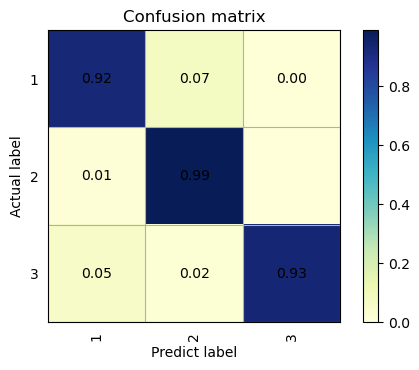

In [ ]:
best_model = np.array(res.iloc[:1,:1])[0].tolist()
y_pred = predictor.predict(X_train,model=best_model)
y_true = y_train

classes = [1,2,3]
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, title='Confusion matrix')

# test performance

## test 1

In [ ]:
test_set1 = pd.read_csv(save_path + "./input/test_set1.csv")
test_set1 = test_set1.drop(columns=["stay_id"])
print(d2_, "samples:",test_set1.shape[0])
y_test = test_set1[label]
X_test = test_set1.drop(columns=[label]) 

predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
print("best model:", predictor.get_model_best())

In [ ]:

print("test set",d2_,"samples:",test_set1.shape[0])
res = predictor.leaderboard(test_set1, silent=True,extra_metrics=['accuracy','balanced_accuracy',"precision_macro","precision_micro","precision_weighted","recall_macro","recall_micro","recall_weighted", 
'f1_weighted',"f1_macro","f1_micro"])
res = res.iloc[:,:14]

model_lst = res.model.unique().tolist()
y_true = y_test
res_eachlabel = pd.DataFrame()
for one_model in model_lst:
    y_pred = predictor.predict(X_test,model=one_model)
    t = classification_report(y_true, y_pred, target_names=["1","2","3"],output_dict=True)
    df_t = pd.DataFrame.from_dict(t)
    df_t = df_t.drop(["macro avg","weighted avg", 'accuracy'],axis=1)
    df_t.columns = ['C1', 'C2', 'C3'] #, 'macro', 'weighted'
    new_columns = [row + '_' + col for row in df_t.index for col in df_t.columns ]
    df_t = pd.DataFrame(df_t.values.flatten()).T
    df_t.columns = new_columns
    res_eachlabel = pd.concat([res_eachlabel, df_t],axis=0)
res_eachlabel['model'] = model_lst
res_eachlabel = res_eachlabel.filter(regex=r'^(?!support)')

# merge out
res_ = pd.merge(res,res_eachlabel,how="inner",on="model")
res_ = res_.rename(columns={"score_val":"AUC_val","score_test":"AUC_test","f1-score_C1":"f1_C1","f1-score_C2":"f1_C2","f1-score_C3":"f1_C3"})

outname = "result_test_" + str(d2_) +".csv"
print("output:",outname)
res_.to_csv(save_path + "/result/result_test_" + str(d2_) +".csv")
res_.head(2)

['eicu', 'mimic']:
 ExtraTreesGini_BAG_L2


<Figure size 432x288 with 0 Axes>

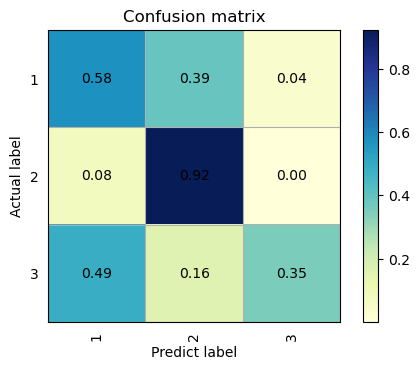

In [ ]:
best_model = [predictor.get_model_best()]  

print(str(d2_)+":\n",str(best_model[0]))
y_true = y_test
y_pred = predictor.predict(X_test,model=best_model)

classes = [1,2,3]
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
plt.figure(figsize=(6,4))
plot_confusion_matrix(cm_normalized, title='Confusion matrix')
tit = save_path + "/result/confusion_matrix_test1.pdf"
plt.savefig(tit, format='pdf')
plt.close()
plt.show()

LightGBMXT_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


XGBoost_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


CatBoost_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBM_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


CatBoost_BAG_L1
LightGBMXT_BAG_L1
RandomForestEntr_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


RandomForestGini_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


NeuralNetTorch_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBM_BAG_L1
ExtraTreesEntr_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


XGBoost_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


ExtraTreesGini_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBMLarge_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


RandomForestEntr_BAG_L1
LightGBMLarge_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


NeuralNetFastAI_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


NeuralNetTorch_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


RandomForestGini_BAG_L1
NeuralNetFastAI_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


ExtraTreesEntr_BAG_L1
ExtraTreesGini_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


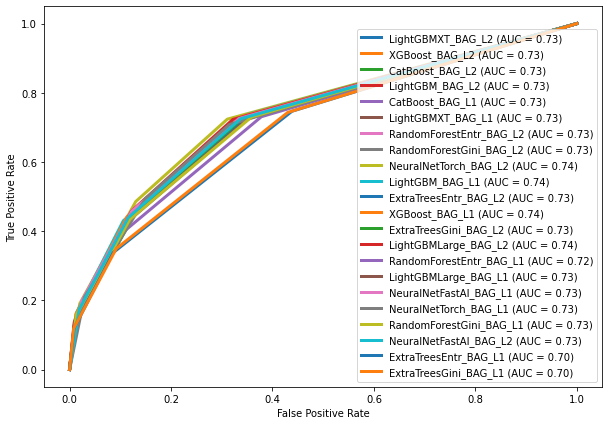

In [21]:
plt.figure(figsize=(10,7))
model_lst = res.model.unique().tolist()
for one_model in model_lst: # [0:3]
    print(one_model)
    fpr, roc_auc = get_aucplot(one_model,X_test,y_test)

In [22]:
# y_pred_proba  = predictor.predict_proba(X_test, as_pandas=True,model=best_model)
# perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred_proba, auxiliary_metrics=True) #,y_pred_proba=y_pred_proba
# print(perf) 

## test 2

In [ ]:
test_set2 = pd.read_csv(save_path + "./input/test_set2.csv")
test_set2 = test_set2.drop(columns=["stay_id"])

print(d3_, "samples:",test_set2.shape[0])
y_test = test_set2[label]
X_test = test_set2.drop(columns=[label]) 

predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
print("best model:", predictor.get_model_best())

In [ ]:

print("test set: ",d3_,"samples:",test_set2.shape[0])
res = predictor.leaderboard(test_set2, silent=True,extra_metrics=['accuracy','balanced_accuracy',"precision_macro","precision_micro","precision_weighted","recall_macro","recall_micro","recall_weighted", 
'f1_weighted',"f1_macro","f1_micro"])
res = res.iloc[:,:14]

model_lst = res.model.unique().tolist()
y_true = y_test
res_eachlabel = pd.DataFrame()
for one_model in model_lst:
    y_pred = predictor.predict(X_test,model=one_model)
    t = classification_report(y_true, y_pred, target_names=["1","2","3"],output_dict=True)
    df_t = pd.DataFrame.from_dict(t)
    df_t = df_t.drop(["macro avg","weighted avg", 'accuracy'],axis=1)
    df_t.columns = ['C1', 'C2', 'C3'] #, 'macro', 'weighted'
    new_columns = [row + '_' + col for row in df_t.index for col in df_t.columns ]
    df_t = pd.DataFrame(df_t.values.flatten()).T
    df_t.columns = new_columns
    res_eachlabel = pd.concat([res_eachlabel, df_t],axis=0)
res_eachlabel['model'] = model_lst
res_eachlabel = res_eachlabel.filter(regex=r'^(?!support)')

# merge out
res_ = pd.merge(res,res_eachlabel,how="inner",on="model")
res_ = res_.rename(columns={"score_val":"AUC_val","score_test":"AUC_test","f1-score_C1":"f1_C1","f1-score_C2":"f1_C2","f1-score_C3":"f1_C3"})

outname = "result_test_" + str(d3_) +".csv"
print("output:",outname)
res_.to_csv(save_path + "/result/result_test_" + str(d3_) +".csv")
res_.head(2)

aumcdb:
 ExtraTreesGini_BAG_L2


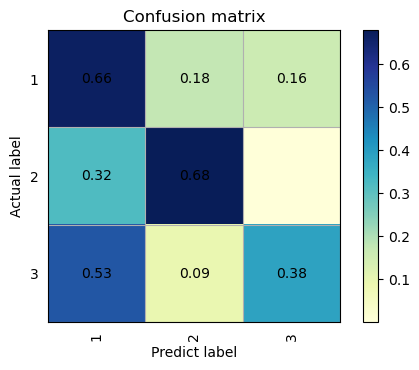

<Figure size 432x288 with 0 Axes>

In [ ]:

best_model = [predictor.get_model_best()]  

print(str(d3_)+":\n",str(best_model[0]))
y_true = y_test
y_pred = predictor.predict(X_test,model=best_model)

classes = [1,2,3]
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot
plot_confusion_matrix(cm_normalized, title='Confusion matrix')
tit = save_path + "/result/confusion_matrix_test2.png"
plt.savefig(tit, format='png')
plt.show()

LightGBMXT_BAG_L1
CatBoost_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


ExtraTreesGini_BAG_L1
ExtraTreesEntr_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


RandomForestEntr_BAG_L1
XGBoost_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBM_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBMXT_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBMLarge_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


ExtraTreesEntr_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


CatBoost_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


ExtraTreesGini_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBM_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


XGBoost_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


RandomForestEntr_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


NeuralNetFastAI_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


RandomForestGini_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


RandomForestGini_BAG_L1
NeuralNetTorch_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


NeuralNetTorch_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


LightGBMLarge_BAG_L2


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


NeuralNetFastAI_BAG_L1


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


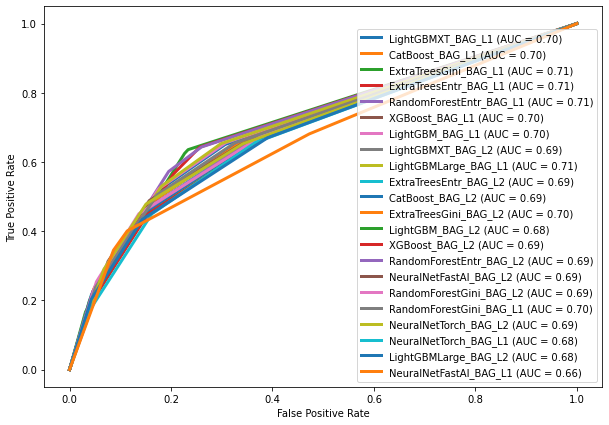

In [26]:
plt.figure(figsize=(10,7))
model_lst = res.model.unique().tolist()
for one_model in model_lst: # [0:3]
    print(one_model)
    fpr, roc_auc = get_aucplot(one_model,X_test,y_test)

In [27]:
# y_pred_proba  = predictor.predict_proba(X_test, as_pandas=True)# ,model=["CatBoost_BAG_L1","ExtraTreesEntr_BAG_L1","WeightedEnsemble_L2"])
# perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred_proba, auxiliary_metrics=True) #,y_pred_proba=y_pred_proba
# print(perf) 

# Feature importance
https://github.com/autogluon/autogluon/blob/master/examples/tabular/interpret/SHAP%20with%20AutoGluon-Tabular.ipynb

In [ ]:
test_set1 = pd.read_csv(save_path + "./input/test_set1.csv")
test_set1 = test_set1.drop(columns=["stay_id"])
print(d2_, "samples:",test_set1.shape[0])

label_counts = test_set1[label].value_counts()
sampled_df = pd.DataFrame()
for label_value, count in label_counts.items():
    sampled_df = sampled_df.append(test_set1[test_set1[label] == label_value].sample(n=label_counts[3], replace=False))
test_set1 = sampled_df
print(d2_, "sampled samples:",test_set1.shape[0])

y_test = test_set1[label]
X_test = test_set1.drop(columns=[label]) 

In [29]:
predictor_multi = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
#model_fi = predictor_multi.feature_importance(train_set) # ,model=

In [30]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names, target_class=None):
        self.ag_model = predictor
        self.feature_names = feature_names
        self.target_class = target_class
        if target_class is None and predictor.problem_type != 'regression':
            print("Since target_class not specified, SHAP will explain predictions for each class")
    
    def predict_proba(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        preds = self.ag_model.predict_proba(X)
        if predictor.problem_type == "regression" or self.target_class is None:
            return preds
        else:
            return preds[self.target_class] 

In [31]:
baseline = X_train.sample(1000, random_state=30)

ag_wrapper = AutogluonWrapper(predictor_multi, X_train.columns)
explainer = shap.KernelExplainer(ag_wrapper.predict_proba, baseline)
print("Baseline prediction: \n", ag_wrapper.predict_proba(baseline).mean())  # this is the same as explainer.expected_value

NSHAP_SAMPLES = 100  # how many samples to use to approximate each Shapely value, larger values will be slower

Since target_class not specified, SHAP will explain predictions for each class


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Baseline prediction: 
 1.0    0.291363
2.0    0.597903
3.0    0.110733
dtype: float32


In [42]:
X_test.shape

(477, 100)

In [32]:
shap_values = explainer.shap_values(X_test, nsamples=NSHAP_SAMPLES,model="CatBoost_BAG_L2")
filename = save_path + r'/result/shap_related.pkl'
save_lst = ["shap_values"]
my_save(save_lst, filename, globals())

  0%|          | 0/477 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 75 iterations, i.e. alpha=1.173e-05, with an active set of 47 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 76 iterations, i.e. alpha=1.156e-05, with an active set of 48 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 77 iterations, alpha=1.139e-05, previous alpha=1.093e-05, with an active set of 48 regressors.
Regressors in active set degenerate. Dropping a regressor, after 77 iterations, i.e. alpha=7.060e-06, with an active set of 47 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 78 

Regressors in active set degenerate. Dropping a regressor, after 46 iterations, i.e. alpha=2.040e-05, with an active set of 34 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 109 iterations, alpha=4.240e-06, previous alpha=4.240e-06, with an active set of 48 regressors.
Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.892e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 191 iterations, alpha=1.171e-03, previous alpha=1.165e-03, with an active set of 62 regressors.
Early stopping the lars path, as the residues are small and the current value of alpha is no l

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 112 iterations, alpha=3.630e-07, previous alpha=3.630e-07, with an active set of 49 regressors.
Regressors in active set degenerate. Dropping a regressor, after 101 iterations, i.e. alpha=2.685e-05, with an active set of 47 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 101 iterations, i.e. alpha=2.685e-05, with an active set of 47 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 103 iterations, i.e. alpha=2.622e-05, with an active set of 47 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after

Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.454e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=5.901e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.347e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 51 iterations, alpha=1.897e-04, previous alpha=1.895e-04, with an active set of 24 regressors.
Regressors in active set degenerate. Dropping a regressor, after 28 it

Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=2.059e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=1.176e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 140 iterations, alpha=2.798e-05, previous alpha=2.798e-05, with an active set of 47 regressors.
Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=4.168e-06, with an active set of 49 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 89

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 80 iterations, alpha=3.632e-06, previous alpha=3.632e-06, with an active set of 47 regressors.
Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=4.031e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 102 iterations, alpha=6.809e-04, previous alpha=6.809e-04, with an active set of 39 regressors.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 91 iterations, alpha=1.346e-05, previous alpha=1.280e-05, with an active set of 42 regressors.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 52 ite

## Beeswarm plot

In [33]:
filename = save_path + r'/result/shap_related.pkl'
my_load(filename, globals())

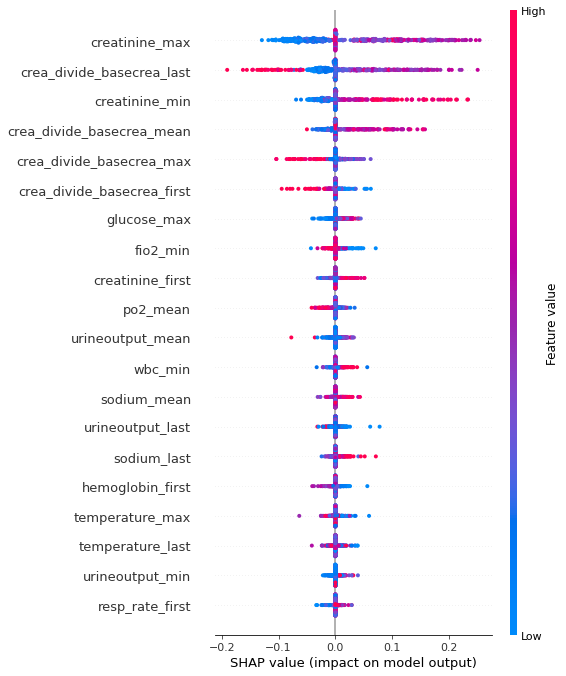

In [34]:
shap.summary_plot(shap_values[0], X_test, show=False) #,save=True,path=pth,show=False
tit = save_path + "/result/shap_beeswarm_test_C1.pdf"
plt.savefig(tit, format='pdf')
plt.show()

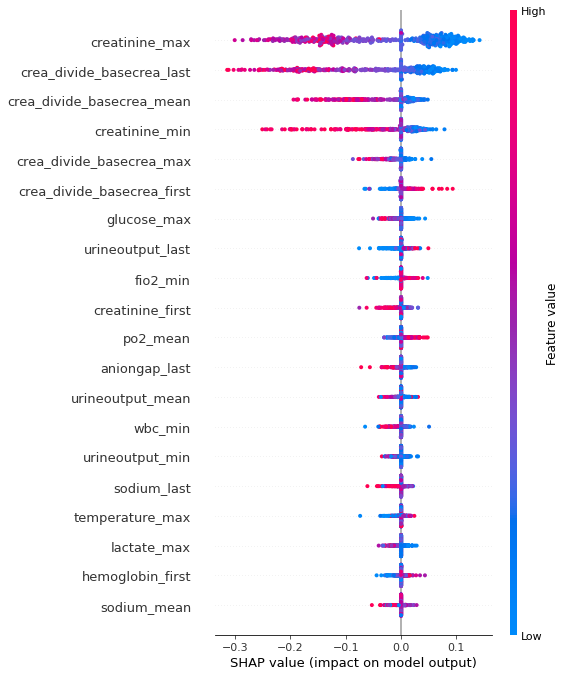

In [35]:
shap.summary_plot(shap_values[1], X_test, show=False)
tit = save_path + "/result/shap_beeswarm_test_C2.pdf"
plt.savefig(tit, format='pdf')
plt.show()

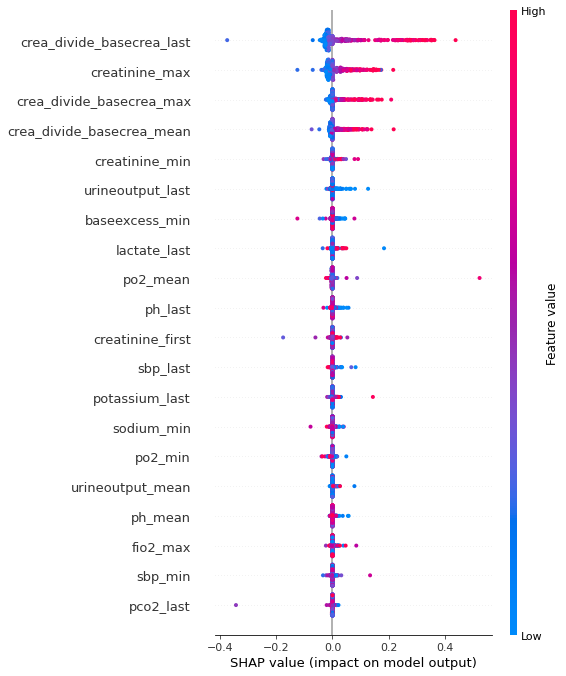

In [36]:
shap.summary_plot(shap_values[2], X_test, show=False)
tit = save_path + "/result/shap_beeswarm_test_C3.pdf"
plt.savefig(tit, format='pdf')
plt.show()

## Force_plot

## bar 1

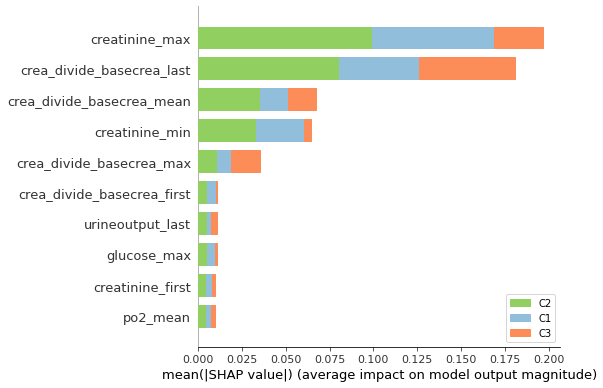

In [38]:
# shap.summary_plot(shap_values, X_test, show = False, max_display=10, plot_type="bar")#, feature_names = np.array(["C1","C2","C3"])) #
# plt.tight_layout()
# plt.show()
# print({"Class "+str(i) : predictor_multi.class_labels[i] for i in range(len(predictor_multi.class_labels))})

num_unit = 10
shap.summary_plot(shap_values, X_test, show = False, max_display=num_unit, plot_type="bar") 
colors = ["#91cf60","#91bfdb","#fc8d59"]
bars = plt.gca().patches

for i, bar in enumerate(bars):
    j = 0 
    if i >= num_unit:
        j = 1
    if i >= num_unit*2:
        j = 2
    bar.set_color(colors[j]) #colors[i % len(colors)]
    
labels = ['C2', 'C1', 'C3']  
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(handles, labels)
tit = save_path + "/result/shap_bar_test.pdf"
plt.savefig(tit, format='pdf')
plt.show()

## bar 2

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


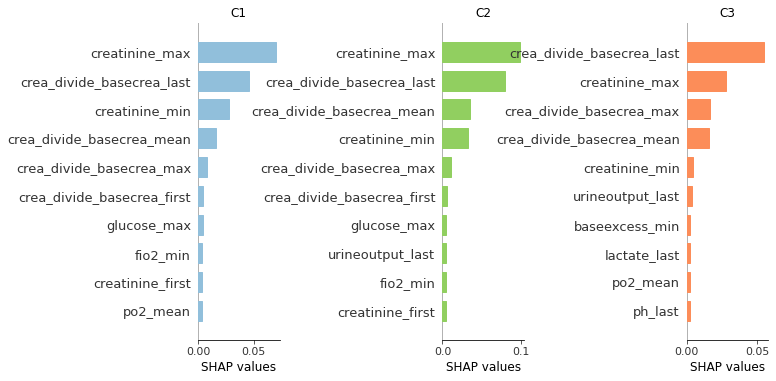

In [39]:
fig = plt.figure(figsize=(30,5))

ax0 = fig.add_subplot(131)
ax0.title.set_text('C1')
shap.summary_plot(shap_values[0], X_test, plot_type="bar", show=False, max_display=10)
bars = plt.gca().patches
for i, bar in enumerate(bars):
    bar.set_color(colors[1])
ax0.set_xlabel(r'SHAP values', fontsize=12)
plt.subplots_adjust(wspace = 2)

ax1 = fig.add_subplot(132)
ax1.title.set_text('C2')
shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=False, max_display=10)
plt.subplots_adjust(left=0.001, right=0.99, bottom=0.1, top=0.9)
bars = plt.gca().patches
for i, bar in enumerate(bars):
    bar.set_color(colors[0])
ax1.set_xlabel(r'SHAP values', fontsize=12)

ax2 = fig.add_subplot(133)
ax2.title.set_text('C3')
shap.summary_plot(shap_values[2], X_test, plot_type="bar", show=False, max_display=10)
plt.subplots_adjust(left=0.00001, right=0.99, bottom=0.1, top=0.9)
bars = plt.gca().patches
for i, bar in enumerate(bars):
    bar.set_color(colors[2])
ax2.set_xlabel(r'SHAP values', fontsize=12)
plt.tight_layout(pad=10)  
tit = save_path + "/result/shap_bar2_test.pdf"
plt.savefig(tit, format='pdf')

plt.show()

In [40]:
# ROW_INDEX = 0  # index of an example datapoint
# class_of_interest = 1  # can be any value in set(y_train)
# class_index = predictor_multi.class_labels.index(class_of_interest)

# single_datapoint = X_train.iloc[[ROW_INDEX]]
# single_prediction = ag_wrapper.predict_proba(single_datapoint)

# shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
# print("Shapely values: \n", {predictor_multi.class_labels[i]:shap_values_single[i] for i in range(len(predictor_multi.class_labels))})

# print(f"Force_plot for class: {class_of_interest}")
# shap.force_plot(explainer.expected_value[class_index], shap_values_single[class_index], X_train.iloc[ROW_INDEX,:])

# some knowledge

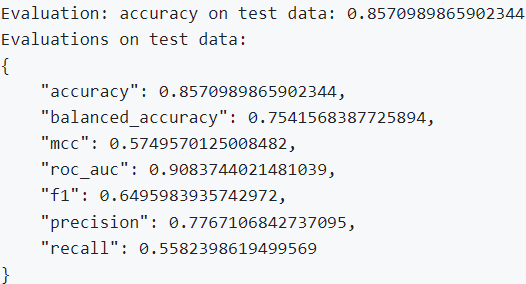

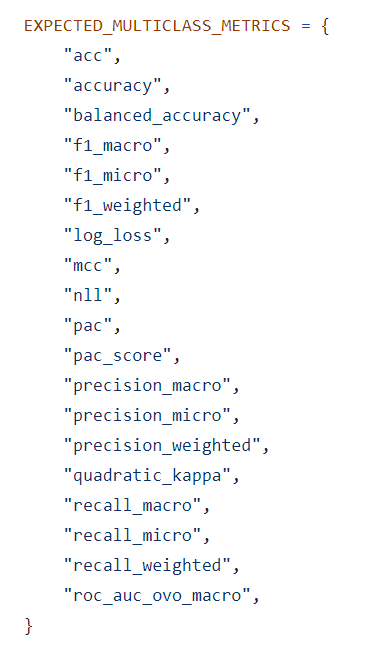

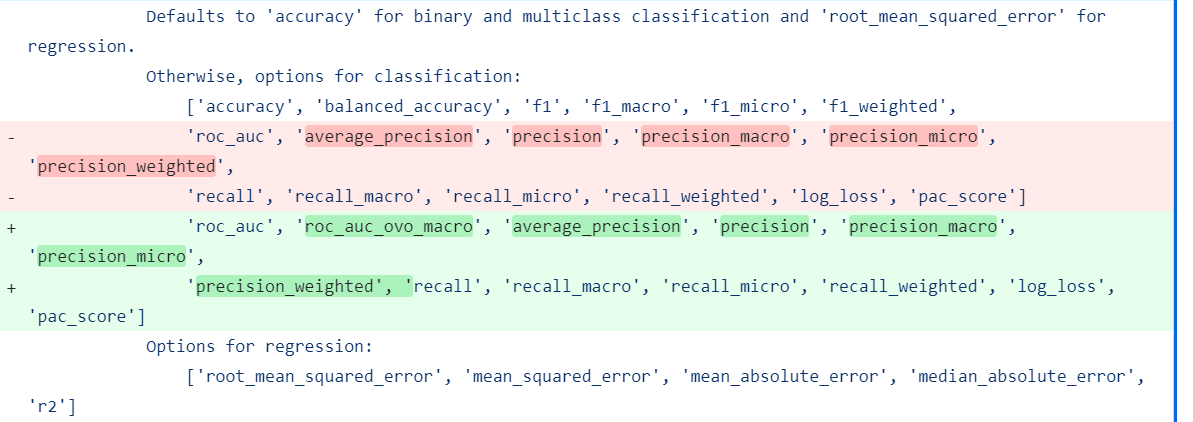

In [41]:
# https://docs.aws.amazon.com/zh_cn/sagemaker/latest/dg/autogluon-tabular-HowItWorks.html

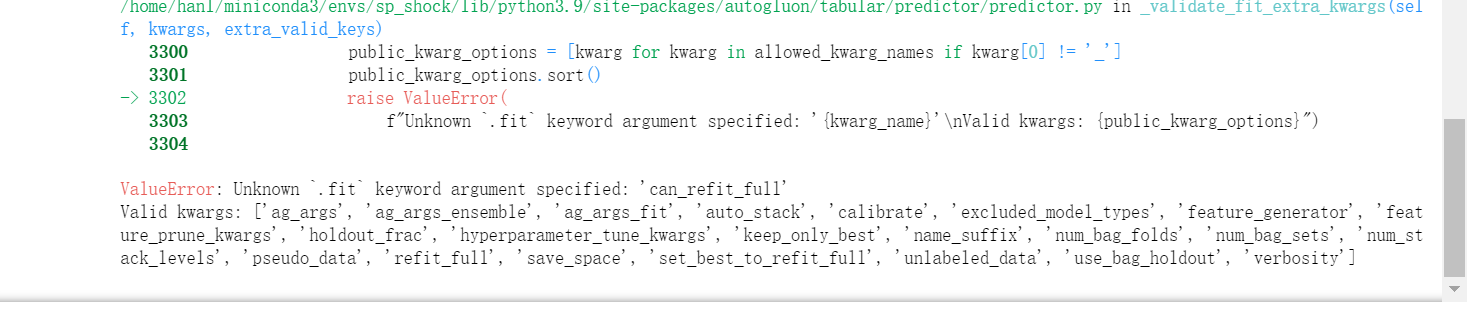